<img src='./img/logo_header.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='100%'></img>

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./13_Metop-AB_IASI_CO.ipynb"><< 13 - Metop A/B IASI CO </a><span style="float:right;"><a href="./22_Sentinel-3_SLSTR_FRP.ipynb">22 - Sentinel-3 SLSTR FRP >></a></span>

# 2.1 Sentinel-3 OLCI Level-1 RGB data

###  Example Portugal fires in July 2020

Sentinel-3 OLCI Level-1 data products are available as Full (`OL_1_EFR`) and Reduced Resolution (`OL_1_ERR`) data files. The following notebook shows you how `OL_1_EFR` data are structured and how you can generate a RGB True- and False-Color image.

Sentinel-3 OLCI data products are disseminated as `.zip archives`, containing data files in `NetCDF` format.

Find more information on the OLCI data products in the [Sentinel-3 OLCI User Guide](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-3-olci).

This notebook provides an introduction to the Sentinel-3 OLCI data and enables you to generate a RGB True- and False-Color image of the **Portugal wildfires** which occured between 25 and 27 July 2020.

#### This module has the following outline:
* [1 - Load and browse Sentinel-3 OLCI Level-1 data](#load_browse)
* [2 - Load OLCI channel information as xarray](#channel_info)
* [3 - Load OLCI geographic coordinates as xarray](#load_geo_coords)
* [4 - Select OLCI channels for a RGB image](#channel_select)
* [5 - Advanced image processing - Normalization and histogram equalization](#image_processing)
* [6 - Visualize a georeferenced RGB True Color image with pcolormesh](#visualize_tc)
* [7 - Create a False Color RGB image and plot it as georeferenced image ](#false_color)

#### Load required libraries

In [2]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from skimage import exposure

import glob

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
warnings.simplefilter(action = "ignore", category = UserWarning)

##### Load helper functions

In [3]:
%run ./functions.ipynb

<hr>

## <a id='load_browse'></a>Load and browse Sentinel-3 OLCI Level-1 data

Sentinel-3 Level-1 data are dissiminated as `.zip archives` when downloaded. The unzipped folder contains 30 data files in `NetCDF` format. Data for each channel is stored in a single `NetCDF` file. Additionally, you get information on `qualityFlags`, `time_coordinates` or `geo_coordinates`.

You can see the names of the 30 data files by looping through the data directory. You see that the channel information follow the same naming and all end with `_radiance.nc`.

In [55]:
olci_dir = './eodata/sentinel3/olci/2020/07/26/S3A_OL_1_EFR____20200726T104604_20200726T104904_20200727T145020_0179_061_051_2340_LN1_O_NT_002.SEN3/'
for i in glob.glob(olci_dir+'*.nc'):
    tmp = i.split('/')
    print(tmp[8])

time_coordinates.nc
instrument_data.nc
tie_geo_coordinates.nc
tie_geometries.nc
qualityFlags.nc
geo_coordinates.nc
Oa08_radiance.nc
Oa05_radiance.nc
Oa16_radiance.nc
Oa07_radiance.nc
Oa15_radiance.nc
Oa13_radiance.nc
Oa06_radiance.nc
Oa11_radiance.nc
Oa09_radiance.nc
Oa20_radiance.nc
Oa17_radiance.nc
Oa01_radiance.nc
removed_pixels.nc
Oa12_radiance.nc
Oa04_radiance.nc
Oa14_radiance.nc
tie_meteo.nc
Oa19_radiance.nc
Oa02_radiance.nc
Oa03_radiance.nc
Oa18_radiance.nc
Oa10_radiance.nc
Oa21_radiance.nc


## <a id='channel_info'></a>Load OLCI channel information as `xarray`

#### Load one single channel

As a first step, you can load one channel with xarray's function `open_dataset`. This will help you to understand how the data is structured.
You see that the data of each channel is a two dimensional data array, with `rows` and `columns` as dimensions. 

In [32]:
olci_xr = xr.open_dataset(olci_dir+'Oa01_radiance.nc')
olci_xr

<xarray.Dataset>
Dimensions:        (columns: 4865, rows: 4090)
Dimensions without coordinates: columns, rows
Data variables:
    Oa01_radiance  (rows, columns) float32 ...
Attributes:
    absolute_orbit_number:  23124
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2020-07-27T14:50:20Z
    history:                  2020-07-27T14:50:20Z: PUGCoreProcessor /data/ip...
    institution:            LN1
    netCDF_version:         4.2 of Mar 13 2018 10:14:33 $
    product_name:           S3A_OL_1_EFR____20200726T104604_20200726T104904_2...
    references:             S3IPF PDS 004.1 - i2r2 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.08
    start_time:             2020-07-26T10:46:03.838332Z
    stop_time:              2020-07-26T10:49:03.759313Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

#### Load all channel information into one xarray object

The next step is to bring the individual data files together into one `xarray` data object. You can do this with xarray's function `open_mfdataset`. Since all channel files have the same data structure, you can combine all channels by coordinates using the keyword argument `by_coords`. The result is a `xarray` object with 21 data variables. Each channel is represented as a data variable.

In [33]:
olci_xr_mf = xr.open_mfdataset(olci_dir+'*_radiance.nc', combine='by_coords')
olci_xr_mf

<xarray.Dataset>
Dimensions:        (columns: 4865, rows: 4090)
Dimensions without coordinates: columns, rows
Data variables:
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa07_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa08_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa09_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa10_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa11_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa12_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa13_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa14_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa15_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa16_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa17_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa18_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa19_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa20_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa21_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
Attributes:
    absolute_orbit_number:  23124
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2020-07-27T14:50:20Z
    history:                  2020-07-27T14:50:20Z: PUGCoreProcessor /data/ip...
    institution:            LN1
    netCDF_version:         4.2 of Mar 13 2018 10:14:33 $
    product_name:           S3A_OL_1_EFR____20200726T104604_20200726T104904_2...
    references:             S3IPF PDS 004.1 - i2r2 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.08
    start_time:             2020-07-26T10:46:03.838332Z
    stop_time:              2020-07-26T10:49:03.759313Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

#### Example to plot one channel

To get an impression of the image, you can simply plot one channel of the xarray object with xarray's function  `.plot.imshow()`. Let's plot channel 8 `Oa08_radiance`. The example shows that you can easily visualize the image itself, but without geographic information.

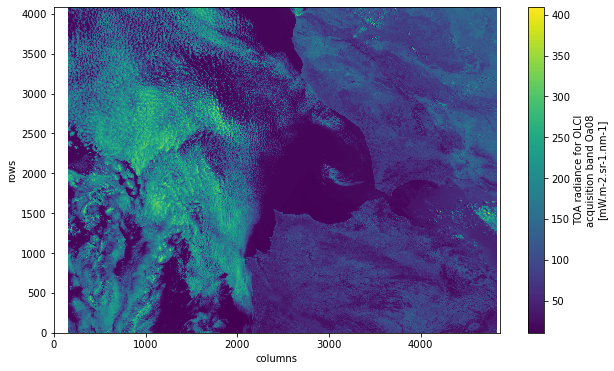

In [34]:
fig = plt.figure(figsize=(10,6))
olci_xr_mf['Oa08_radiance'].plot.imshow()

## <a id='load_geo_coords'></a>Load OLCI geographic coordinates as `xarray`

If you want to georeference your image, you have to load the geographic coordinates file. You can load it as xarray with `open_dataset`. The file is called `geo_coordinates.nc`. You see that the file contains three variables: `latitude`, `longitude` and `altitude`.

Let's store the latitude and longitude data as `lat` and `lon` variables respectively.

In [35]:
olci_geo_coords = xr.open_dataset(olci_dir+'geo_coordinates.nc')
olci_geo_coords

<xarray.Dataset>
Dimensions:    (columns: 4865, rows: 4090)
Dimensions without coordinates: columns, rows
Data variables:
    altitude   (rows, columns) float32 ...
    latitude   (rows, columns) float64 ...
    longitude  (rows, columns) float64 ...
Attributes:
    absolute_orbit_number:  23124
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2020-07-27T14:50:20Z
    history:                  2020-07-27T14:50:20Z: PUGCoreProcessor /data/ip...
    institution:            LN1
    netCDF_version:         4.2 of Mar 13 2018 10:14:33 $
    product_name:           S3A_OL_1_EFR____20200726T104604_20200726T104904_2...
    references:             S3IPF PDS 004.1 - i2r2 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.08
    start_time:             2020-07-26T10:46:03.838332Z
    stop_time:              2020-07-26T10:49:03.759313Z
    title:                  OLCI Level 1b Product, Geo Coordinates Data Set

In [36]:
lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data

## <a id='channel_select'></a>Select OLCI channels for a RGB image

Depending on the combination of different OLCI channels, your RGB image might highlight specific phenomena. The channel combination for a True Color RGB image could be:
- Red: `Oa08_radiance`
- Green: `Oa06_radiance`
- Blue: `Oa04_radiance`

Let's define a function called [select_channels_for_rgb](./ltpy_functions.ipynb#rgb_channels), which makes the channel selection more flexible. The function returns the three bands individually.

In [37]:
def select_channels_for_rgb(xarray, red_channel, green_channel, blue_channel):
    """ 
    Selects the channels / bands of a multi-dimensional xarray for red, green and blue composites.
    
    Parameters:
        xarray(xarray Dataset): xarray Dataset object that stores the different channels / bands.
        red_channel(str): Name of red channel to be selected
        green_channel(str): Name of green channel to be selected
        blue_channel(str): Name of blue channel to be selected

    Returns:
        Three xarray DataArray objects with selected channels / bands
    """  
    return xarray[red_channel], xarray[green_channel], xarray[blue_channel]

In [38]:
red, green, blue = select_channels_for_rgb(olci_xr_mf, 'Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance')
red

<xarray.DataArray 'Oa08_radiance' (rows: 4090, columns: 4865)>
dask.array<open_dataset-1f824d6c804234404899c1a15bad12f0Oa08_radiance, shape=(4090, 4865), dtype=float32, chunksize=(4090, 4865), chunktype=numpy.ndarray>
Dimensions without coordinates: rows, columns
Attributes:
    ancillary_variables:  Oa08_radiance_err
    coordinates:          time_stamp altitude latitude longitude
    long_name:            TOA radiance for OLCI acquisition band Oa08
    standard_name:        toa_upwelling_spectral_radiance
    units:                mW.m-2.sr-1.nm-1
    valid_max:            65534
    valid_min:            0

## <a id='image_processing'></a>Advanced image processing - Normalization and histogram equalization

#### Normalization

A common operation in image processing is the normalization of data values. Normalization changes the range of pixel intesity and can improve the constrast.
Let's define a function called [normalize](./ltpy_functions.ipynb#normalize), which normalizes a numpy array into a scale between 0.0 and 1.0.

In [39]:
def normalize(array):
    """ 
    Normalizes a numpy array / xarray DataArray object value to values between 0 and 1.
    
    Parameters:
        xarray(numpy array or xarray DataArray): xarray DataArray or numpy array object.

    Returns:
        Normalized array
    """ 
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

You can now apply the function [normalize](./ltpy_functions.ipynb#normalize) to each RGB channel. At the end, you can bring the three channels together into one `rgb` array with `numpy.dstack`. By verifying the shape of the resulting array, you see that the `rgb` array has now three dimensions.

In [40]:
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

In [41]:
rgb = np.dstack((redn, greenn, bluen))
rgb.shape

(4090, 4865, 3)

You can now plot the rgb image to see if maybe further image processing methods could be applied. If you visualize the image with `plt.imshow()`, you see that the constrast is not very strong. A further step is to sharpen the contrast with the help of a **Histogram equalization**.

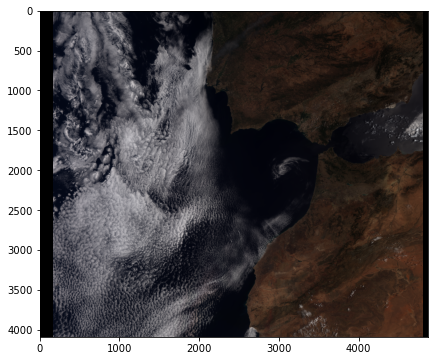

In [42]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

#### Histogram equalization

Histogram equalization is a method in image processing that adjusts the contrast using the image's histogram. Python's `skikit-learn` library has useful tools to make a histogram equalization quite straighforward. The `skimage` library provides a function `exposure.equalize_adaphtist()` which can be applied to the rgb data array.

In [43]:
rgb = exposure.equalize_adapthist(rgb)

You can again plot the rgb image with `plt.imshow()`. You can see that the histogram equalization improved the contrast of the image.

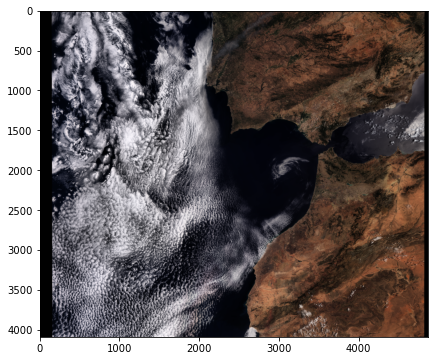

In [44]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

## <a id='visualize_tc'></a>Visualize a georeferenced RGB True Color image with `pcolormesh`

The final step is to georeference the `RGB` image. Therefore, you need the extracted `lat` and `lon` information extracted above.

Let's plot the image with matplotlib's `pcolormesh` function. To be able to visualize the array as RGB, you have to map first the rgb array to a colour array.

In [45]:
mesh_rgb = rgb[:, :-1, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

The last step is to visualize the color array and add additional information, e.g. gridlines and coastlines. As you want to reuse the plotting code again, you can define a function called [visualize_s3_pcolormesh](./ltpy_functions.ipynb#visualize_s3_pcolormesh).

In [46]:
def visualize_s3_pcolormesh(color_array, array, latitude, longitude, title):
    """ 
    Visualizes a numpy array (Sentinel-3 data) with matplotlib's 'pcolormesh' function as RGB image.
    
    Parameters:
        color_array (numpy MaskedArray): any numpy MaskedArray, e.g. loaded with the NetCDF library and the Dataset function
        longitude (numpy Array): array with longitude values
        latitude (numpy Array) : array with latitude values
        title (str): title of the resulting plot
    """
    fig=plt.figure(figsize=(20, 12))

    ax=plt.axes(projection=ccrs.Mercator())
    ax.coastlines()

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}

    img1 = plt.pcolormesh(longitude, latitude, array*np.nan, color=colorTuple,
                          clip_on = True,
                          edgecolors=None,
                          zorder=0,
                          transform=ccrs.PlateCarree())
    ax.set_title(title, fontsize=20, pad=20.0)
    plt.show()

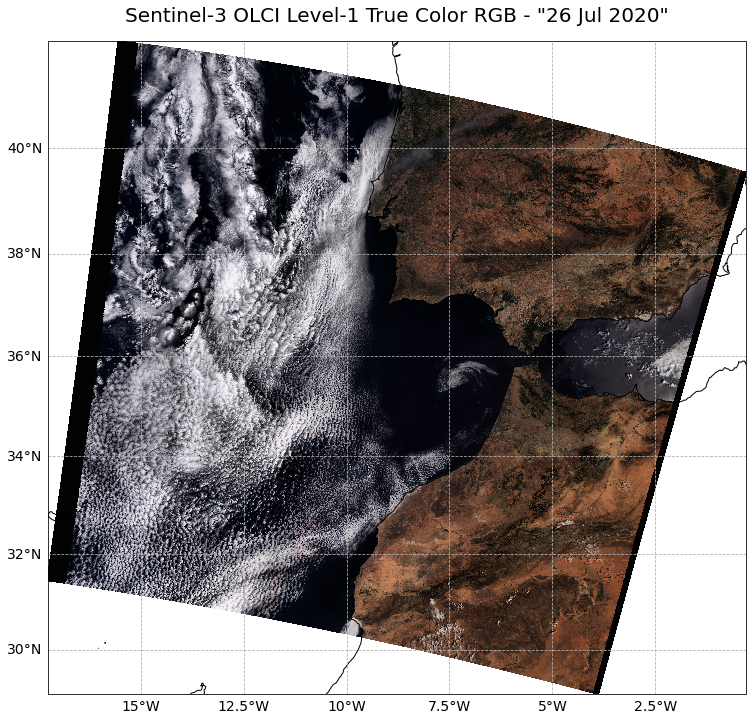

In [47]:
visualize_s3_pcolormesh(color_array=colorTuple,
                        array=red, 
                        latitude=lat, 
                        longitude=lon, 
                        title='Sentinel-3 OLCI Level-1 True Color RGB - "26 Jul 2020"')

<br>

## <a id='false_color'></a>Create a False Color RGB image and plot it as georeferenced image 

A false color RGB image can be applied if specific phenomena should be highlighted. A channel combination for Sentinel-3 OLCI data could be:
- Red: `Oa17_radiance`
- Green: `Oa05_radiance`
- Blue: `Oa02_radiance`

This selection is advantageous to identify burnt areas and wildfires. The combination highlights healthy vegeation as red and burnt areas as black.

Let's repeat the steps from above to visualize the image as False Color RGB composite.

#### Select RGB channels

The first step is to select the channels `Oa17_radiance`, `Oa05_radiance` and `Oa02_radiance` as red, green and blue channels respectively.

In [48]:
red_fc, green_fc, blue_fc = select_channels_for_rgb(olci_xr_mf, 'Oa17_radiance', 'Oa05_radiance', 'Oa02_radiance')

#### Normalize

You also want to normalize these channels and stack them afterwards into a three-dimensional array.

In [49]:
redn_fc = normalize(red_fc)
greenn_fc = normalize(green_fc)
bluen_fc = normalize(blue_fc)

In [50]:
rgb_fc = np.dstack((redn_fc, greenn_fc, bluen_fc))

#### Histogram equalization

Apply histogram equalization.

In [51]:
rgb_fc = exposure.equalize_adapthist(rgb_fc)

Let's have a sneak-peak to the un-georefrenced image with `plt.imshow()`

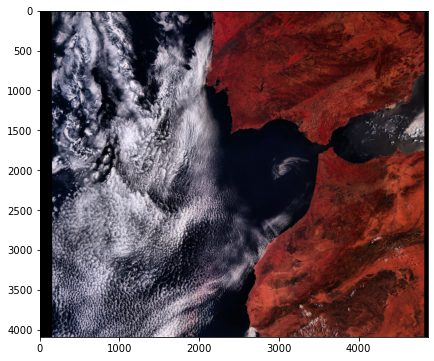

In [52]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb_fc)

#### Visualize with function `visualize_s3_pcolormesh`

In [53]:
mesh_rgb = rgb_fc[:, :-1, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

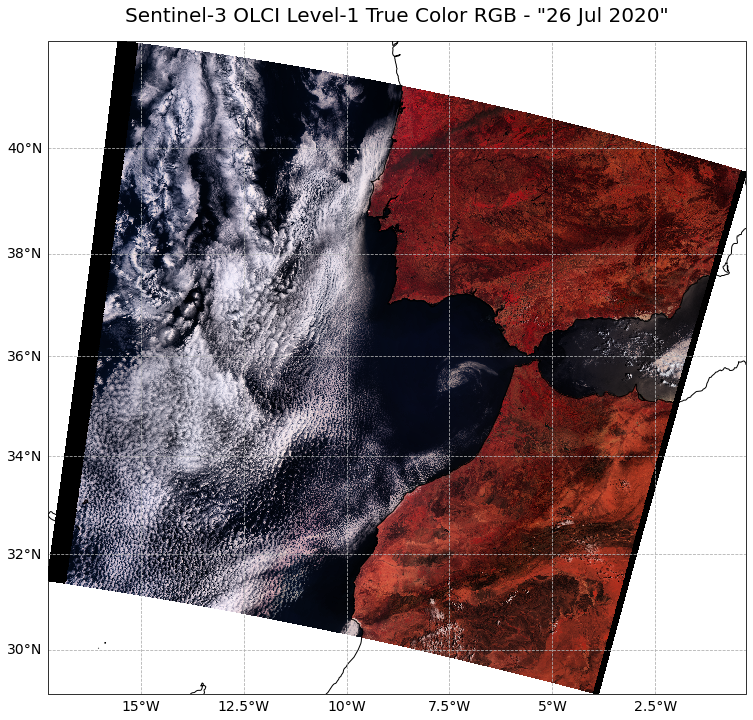

In [54]:
visualize_s3_pcolormesh(color_array=colorTuple,
                        array=red, 
                        latitude=lat, 
                        longitude=lon,
                        title='Sentinel-3 OLCI Level-1 True Color RGB - "26 Jul 2020"',
                       )

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./13_Metop-AB_IASI_CO.ipynb"><< 13 - Metop-A/B IASI CO </a><span style="float:right;"><a href="./22_Sentinel-3_SLSTR_FRP.ipynb">22 - Sentinel-3 SLSTR FRP >></a></span>

<hr>

<img src='./img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.